# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder  
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.preprocessing import RobustScaler

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
import os

import warnings

#from config.data_preprocessing import load_data, clean_data

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Data Import

In [2]:
#load data
file_name = 'Training_Test_Data.csv'
path_to_file = os.path.join(os.getcwd(),'data',file_name)
data_raw = pd.read_csv(path_to_file, sep=';', decimal=',')

/var/folders/9_/k5r65n5n07s301lfrxbbnf140000gn/T/ipykernel_36430/1173368864.py:4: DtypeWarning: Columns (18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(path_to_file, sep=';', decimal=',')


## Data Exploration & Cleaning

“Transport Order ID” - transport order number (index, if required)<br> 
„Exception_Output“ -  historic result of  exception: RED = volume exception occurred, GOOD = no volume exception <br>
Other columns -  available features. These may or may not be useful for the model. You need to choose the important features by yourself.

In [3]:
data_raw.columns

Index(['Transport Order id', 'Loading_meter [ldm]', 'Gross_weight [kg]',
       'Volume [m3]', 'Handling_unit_quantity [qty]',
       'Billed freight weight [kg]', 'Means_of_transportation', 'Carrier ID',
       'Mode_of_Transportation', 'Pickup_weekday', 'Delivery_weekday',
       'Consignor_country', 'Recipient_country', 'Number_of_Stops',
       'Weeks_after_project_GoLive', 'Pickup_Month', 'Pickup_Year',
       'Custom clearance needed', 'Pickup_timewindow_length [hrs]',
       'Delivery_timewindow_length [hrs]',
       'Plant Shutdown on pickup or delivery day',
       'Exception happened 1week ago', 'Exception happened 2weeks ago',
       'Holiday during pickup or delivery day', 'distance cluster',
       'Pickup_weeknumber', 'Delivery_weeknumber', 'Exception_output'],
      dtype='object')

In [4]:
data_raw.head(5)

,Transport Order id,Loading_meter [ldm],Gross_weight [kg],Volume [m3],Handling_unit_quantity [qty],Billed freight weight [kg],Means_of_transportation,Carrier ID,Mode_of_Transportation,Pickup_weekday,Delivery_weekday,Consignor_country,Recipient_country,Number_of_Stops,Weeks_after_project_GoLive,Pickup_Month,Pickup_Year,Custom clearance needed,Pickup_timewindow_length [hrs],Delivery_timewindow_length [hrs],Plant Shutdown on pickup or delivery day,Exception happened 1week ago,Exception happened 2weeks ago,Holiday during pickup or delivery day,distance cluster,Pickup_weeknumber,Delivery_weeknumber,Exception_output
0,VBDK1645,13.0,14136.72,92.66,78,14136.72,mega,CHOM01,FTL,Dienstag,Freitag,PL,ES,1.0,95.0,7.0,2017.0,0.0,2.0,2.0,False,False,False,False,>1800 km,28,28,Good
1,VBEF1807,13.0,14136.72,92.66,78,14136.72,Mega,CHOM01,FTL,Freitag,Mittwoch,PL,ES,1.0,96.0,7.0,2017.0,0.0,2.0,2.0,False,False,False,True,>1800 km,28,29,Good
2,VBEMAWJR,13.5,7000.00,97.20,72,14580.00,Mega,RABE01,FTL,Dienstag,Mittwoch,PL,DE,1.0,9.0,7.0,2017.0,0.0,2.0,2.0,False,False,False,False,500-800 km,28,28,Good
3,VBEMAWJT,13.5,7000.00,97.20,72,14580.00,Mega,RABE01,FTL,Donnerstag,Freitag,PL,DE,1.0,9.0,7.0,2017.0,0.0,2.0,2.0,False,False,False,False,500-800 km,28,28,Good
4,VBEMAWKW,13.0,24000.00,93.60,78,24000.00,meGa,SOST01,FTL,Dienstag,Mittwoch,PL,DE,1.0,27.0,7.0,2017.0,0.0,1.0,1.0,False,False,False,False,800-1300 km,28,28,Good


In [5]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Loading_meter [ldm],94460.0,3.470031,4.536706,0.00,0.40,1.1425,4.53000,34.40
Gross_weight [kg],94460.0,1777.043527,3003.698194,0.89,122.00,448.0250,2144.61000,31087.90
Volume [m3],94460.0,18.505672,30.156006,0.00,1.01,3.1200,17.95075,184.75
Handling_unit_quantity [qty],94460.0,19.955547,97.963709,1.00,1.00,4.0000,18.00000,2380.00
Billed freight weight [kg],94460.0,3266.208632,4755.278427,1.01,193.15,658.0800,4160.00000,31087.90
Pickup_weeknumber,94460.0,31.569606,13.788351,1.00,22.00,35.0000,43.00000,52.00
Delivery_weeknumber,94460.0,32.111253,13.790550,1.00,22.00,36.0000,43.00000,52.00


In [6]:
data_raw.isnull().sum()

Transport Order id                            0
Loading_meter [ldm]                           0
Gross_weight [kg]                             0
Volume [m3]                                   0
Handling_unit_quantity [qty]                  0
Billed freight weight [kg]                    0
Means_of_transportation                       1
Carrier ID                                    3
Mode_of_Transportation                        0
Pickup_weekday                              952
Delivery_weekday                            959
Consignor_country                           935
Recipient_country                           966
Number_of_Stops                             929
Weeks_after_project_GoLive                  944
Pickup_Month                                947
Pickup_Year                                 914
Custom clearance needed                     991
Pickup_timewindow_length [hrs]              936
Delivery_timewindow_length [hrs]            930
Plant Shutdown on pickup or delivery day

In [7]:
data_raw.shape

(94460, 28)

### rename some columns for better handling

In [8]:
data_preprocessing = data_raw.rename(columns={"Loading_meter [ldm]" : "Loading_meter_ldm", 
                                              "Gross_weight [kg]" : "Gross_weight_kg",
                                              "Volume [m3]" : "Volume_m3",
                                              "Handling_unit_quantity [qty]" :"Handling_unit_quantity_qty",
                                              "Billed freight weight [kg]" : "Billed_freight_weight_kg",
                                              "Carrier ID": "Carrier_ID",
                                              "Custom clearance needed" : "Custom_clearance_needed",
                                              "Pickup_timewindow_length [hrs]" : "Pickup_timewindow_length_hrs",
                                              "Delivery_timewindow_length [hrs]" : "Delivery_timewindow_length_hrs",
                                              "Plant Shutdown on pickup or delivery day" : "Plant_Shutdown_on_pickup_or_delivery_day",
                                              "Exception happened 1week ago": "Exception_happened_1week_ago",
                                              "Exception happened 2weeks ago" : "Exception_happened_2weeks_ago",
                                              "Holiday during pickup or delivery day" : "Holiday_during_pickup_or_delivery_day",
                                              "distance cluster" : "distance_cluster",
                                             })

In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94460 entries, 0 to 94459
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Transport Order id                        94460 non-null  object 
 1   Loading_meter [ldm]                       94460 non-null  float64
 2   Gross_weight [kg]                         94460 non-null  float64
 3   Volume [m3]                               94460 non-null  float64
 4   Handling_unit_quantity [qty]              94460 non-null  int64  
 5   Billed freight weight [kg]                94460 non-null  float64
 6   Means_of_transportation                   94459 non-null  object 
 7   Carrier ID                                94457 non-null  object 
 8   Mode_of_Transportation                    94460 non-null  object 
 9   Pickup_weekday                            93508 non-null  object 
 10  Delivery_weekday                  

### adjust data types

In [10]:
#target variable into categorical
le = LabelEncoder()
data_preprocessing['Exception_output'] = le.fit_transform(data_preprocessing['Exception_output'])

In [11]:
#automatic data type conversion
data_preprocessing_conv = data_preprocessing.convert_dtypes()
data_preprocessing_conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94460 entries, 0 to 94459
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Transport Order id                        94460 non-null  string 
 1   Loading_meter_ldm                         94460 non-null  Float64
 2   Gross_weight_kg                           94460 non-null  Float64
 3   Volume_m3                                 94460 non-null  Float64
 4   Handling_unit_quantity_qty                94460 non-null  Int64  
 5   Billed_freight_weight_kg                  94460 non-null  Float64
 6   Means_of_transportation                   94459 non-null  string 
 7   Carrier_ID                                94457 non-null  string 
 8   Mode_of_Transportation                    94460 non-null  string 
 9   Pickup_weekday                            93508 non-null  string 
 10  Delivery_weekday                  

In [12]:
# count of na in each column
data_preprocessing_conv.isna().sum()

Transport Order id                            0
Loading_meter_ldm                             0
Gross_weight_kg                               0
Volume_m3                                     0
Handling_unit_quantity_qty                    0
Billed_freight_weight_kg                      0
Means_of_transportation                       1
Carrier_ID                                    3
Mode_of_Transportation                        0
Pickup_weekday                              952
Delivery_weekday                            959
Consignor_country                           935
Recipient_country                           966
Number_of_Stops                             929
Weeks_after_project_GoLive                  944
Pickup_Month                                947
Pickup_Year                                 914
Custom_clearance_needed                     991
Pickup_timewindow_length_hrs                936
Delivery_timewindow_length_hrs              930
Plant_Shutdown_on_pickup_or_delivery_day

In [13]:
print('pickup time window #NAME points',len(data_preprocessing_conv[data_preprocessing_conv.Pickup_timewindow_length_hrs == "#NAME?"]))
print('delivery time window #NAME points',len(data_preprocessing_conv[data_preprocessing_conv.Delivery_timewindow_length_hrs == "#NAME?"]))

pickup time window #NAME points 33
delivery time window #NAME points 4


Manual data type conversion: <br>
- Number_of_Stops from string to float
- Weeks_after_project_GoLive from string to float
- Pickup_Month from string to float
- Pickup_Year from string to float
- Custom_clearance_needed from string to float

- Pickup_timewindow_length_hrs from object to float (remove #Name?)
- Delivery_timewindow_length_hrs from object to float (remove #Name?)

### replace missing values with -999

In [14]:
data_preprocessing_conv_replace_nan = data_preprocessing_conv.copy()
data_preprocessing_conv_replace_nan["Number_of_Stops"] = data_preprocessing_conv_replace_nan.Number_of_Stops.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Weeks_after_project_GoLive'] = data_preprocessing_conv_replace_nan.Weeks_after_project_GoLive.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Pickup_Month'] = data_preprocessing_conv_replace_nan.Pickup_Month.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Pickup_Year'] = data_preprocessing_conv_replace_nan.Pickup_Year.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Custom_clearance_needed'] = data_preprocessing_conv_replace_nan.Custom_clearance_needed.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Pickup_timewindow_length_hrs'] = data_preprocessing_conv_replace_nan.Pickup_timewindow_length_hrs.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Pickup_timewindow_length_hrs'] = data_preprocessing_conv_replace_nan['Pickup_timewindow_length_hrs'].replace({'#NAME?':'-999'})
data_preprocessing_conv_replace_nan['Delivery_timewindow_length_hrs'] = data_preprocessing_conv_replace_nan.Delivery_timewindow_length_hrs.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Delivery_timewindow_length_hrs'] = data_preprocessing_conv_replace_nan['Delivery_timewindow_length_hrs'].replace({'#NAME?':'-999'})
data_preprocessing_conv_replace_nan['Pickup_weekday'] = data_preprocessing_conv_replace_nan.Pickup_weekday.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Delivery_weekday'] = data_preprocessing_conv_replace_nan.Delivery_weekday.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Consignor_country'] = data_preprocessing_conv_replace_nan.Consignor_country.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Recipient_country'] = data_preprocessing_conv_replace_nan.Recipient_country.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Means_of_transportation'] = data_preprocessing_conv_replace_nan.Means_of_transportation.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan['Carrier_ID'] = data_preprocessing_conv_replace_nan.Carrier_ID.replace(np.nan,'-999',regex = True)

#for boolean variables
not_Nas_df_Plant_Shutdown_on_pickup_or_delivery_day = data_preprocessing_conv_replace_nan[~data_preprocessing_conv_replace_nan['Plant_Shutdown_on_pickup_or_delivery_day'].isna()]
data_preprocessing_conv_replace_nan["Plant_Shutdown_on_pickup_or_delivery_day"] = not_Nas_df_Plant_Shutdown_on_pickup_or_delivery_day["Plant_Shutdown_on_pickup_or_delivery_day"].astype(int)
data_preprocessing_conv_replace_nan['Plant_Shutdown_on_pickup_or_delivery_day'] = data_preprocessing_conv_replace_nan.Plant_Shutdown_on_pickup_or_delivery_day.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan["Plant_Shutdown_on_pickup_or_delivery_day"] = data_preprocessing_conv_replace_nan["Plant_Shutdown_on_pickup_or_delivery_day"].astype(int)


not_Nas_df_Exception_happened_1week_ago = data_preprocessing_conv_replace_nan[~data_preprocessing_conv_replace_nan['Exception_happened_1week_ago'].isna()]
data_preprocessing_conv_replace_nan["Exception_happened_1week_ago"] = not_Nas_df_Exception_happened_1week_ago["Exception_happened_1week_ago"].astype(int)
data_preprocessing_conv_replace_nan['Exception_happened_1week_ago'] = data_preprocessing_conv_replace_nan.Exception_happened_1week_ago.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan["Exception_happened_1week_ago"] = data_preprocessing_conv_replace_nan["Exception_happened_1week_ago"].astype(int)

not_Nas_df_Exception_happened_2weeks_ago = data_preprocessing_conv_replace_nan[~data_preprocessing_conv_replace_nan['Exception_happened_2weeks_ago'].isna()]
data_preprocessing_conv_replace_nan["Exception_happened_2weeks_ago"] = not_Nas_df_Exception_happened_2weeks_ago["Exception_happened_2weeks_ago"].astype(int)
data_preprocessing_conv_replace_nan['Exception_happened_2weeks_ago'] = data_preprocessing_conv_replace_nan.Exception_happened_2weeks_ago.replace(np.nan,'-999',regex = True)
data_preprocessing_conv_replace_nan["Exception_happened_2weeks_ago"] = data_preprocessing_conv_replace_nan["Exception_happened_2weeks_ago"].astype(int)

In [15]:
#change datatypes to int
data_preprocessing_conv_replace_nan["Number_of_Stops"] = data_preprocessing_conv_replace_nan['Number_of_Stops'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Weeks_after_project_GoLive"] = data_preprocessing_conv_replace_nan['Weeks_after_project_GoLive'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Pickup_Month"] = data_preprocessing_conv_replace_nan['Pickup_Month'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Pickup_Year"] = data_preprocessing_conv_replace_nan['Pickup_Year'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Custom_clearance_needed"] = data_preprocessing_conv_replace_nan['Custom_clearance_needed'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Pickup_timewindow_length_hrs"] = data_preprocessing_conv_replace_nan['Pickup_timewindow_length_hrs'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Delivery_timewindow_length_hrs"] = data_preprocessing_conv_replace_nan['Delivery_timewindow_length_hrs'].astype(float).round().astype(int)
data_preprocessing_conv_replace_nan["Holiday_during_pickup_or_delivery_day"] = data_preprocessing_conv_replace_nan['Holiday_during_pickup_or_delivery_day'].astype(int)

### make tranport order id the index

In [16]:
#make tranport order id the index
data_preprocessing_conv_replace_nan = data_preprocessing_conv_replace_nan.set_index('Transport Order id')

In [17]:
data_preprocessing_conv_replace_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94460 entries, VBDK1645 to VBYR1649
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Loading_meter_ldm                         94460 non-null  Float64
 1   Gross_weight_kg                           94460 non-null  Float64
 2   Volume_m3                                 94460 non-null  Float64
 3   Handling_unit_quantity_qty                94460 non-null  Int64  
 4   Billed_freight_weight_kg                  94460 non-null  Float64
 5   Means_of_transportation                   94460 non-null  string 
 6   Carrier_ID                                94460 non-null  string 
 7   Mode_of_Transportation                    94460 non-null  string 
 8   Pickup_weekday                            94460 non-null  string 
 9   Delivery_weekday                          94460 non-null  string 
 10  Consignor_country            

### convert string to int for relevant columns

In [18]:
data_preproc_conv_no_nans = data_preprocessing_conv_replace_nan.copy()

In [19]:
#make all transportation modes upper case (to add 3 ltl to LTL)
data_preproc_conv_no_nans.loc[:,"Mode_of_Transportation"] = data_preproc_conv_no_nans["Mode_of_Transportation"].str.upper()

#make all means of transportation lower case
data_preproc_conv_no_nans.loc[:,"Means_of_transportation"] = data_preproc_conv_no_nans["Means_of_transportation"].str.lower()

#translate all weekdays in english
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Montag", "Pickup_weekday"] = "Monday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Dienstag", "Pickup_weekday"] = "Tuesday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Mittwoch", "Pickup_weekday"] = "Wednesday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Donnerstag", "Pickup_weekday"] = "Thursday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Freitag", "Pickup_weekday"] = "Friday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Samstag", "Pickup_weekday"] = "Saturday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Pickup_weekday"] == "Sonntag", "Pickup_weekday"] = "Sunday"

data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Montag", "Delivery_weekday"] = "Monday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Dienstag", "Delivery_weekday"] = "Tuesday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Mittwoch", "Delivery_weekday"] = "Wednesday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Donnerstag", "Delivery_weekday"] = "Thursday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Freitag", "Delivery_weekday"] = "Friday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Samstag", "Delivery_weekday"] = "Saturday"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["Delivery_weekday"] == "Sonntag", "Delivery_weekday"] = "Sunday"

#transform distance cluster into categorical variable
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "0-50 km", "distance_cluster"] = "0"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "50-200 km", "distance_cluster"] = "1"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "200-500 km", "distance_cluster"] = "2"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "500-800 km", "distance_cluster"] = "3"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "800-1300 km", "distance_cluster"] = "4"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == "1300-1800 km", "distance_cluster"] = "5"
data_preproc_conv_no_nans.loc[data_preproc_conv_no_nans["distance_cluster"] == ">1800 km", "distance_cluster"] = "6"


data_preproc_conv_no_nans['distance_cluster'] = data_preproc_conv_no_nans['distance_cluster'].astype(int)

In [20]:
data_preproc_conv_no_nans[["Mode_of_Transportation", 
                          "Means_of_transportation", 
                          "Pickup_weekday",
                           "Delivery_weekday",
                           "Carrier_ID",
                           "Consignor_country",
                           "Recipient_country",
                          ]] = data_preproc_conv_no_nans[["Mode_of_Transportation",
                                                          "Means_of_transportation", 
                                                          "Pickup_weekday",
                                                          "Delivery_weekday",
                                                          "Carrier_ID",
                                                          "Consignor_country",
                                                          "Recipient_country",
                                                         ]].apply(lambda x: pd.factorize(x)[0])

mode of transportation:
- 0 - FTL
- 1 - LTL
- 2 - MR
- 3 - HUB
- 4 - MIXED

means of transportation:
- 0 - mega
- 1 - standard
- 2 - jumbo
- 3 - jumbo swap body
- 4 - mega box
- 5 - high cube container
- 6 - truck 7.5to 
- 7 - transporter 3.5to
- 8 - top shifter
- 9 - big-maxx 
- 10 - truck 12 to
- 11 - big-maxx auflieger
- 12 - long liner
- 13 - truck 7.5to nlaengei=6.5
- 14 - truck 5 to
- 15 - long gazelle rus
- 16 - curtain side van

Pickup_weekday
- 0 - Tuesday
- 1 - Friday
- 2 - Thursday
- 3 - Wednesday
- 4 - Saturday
- 5 - Monday
- 6 - Sunday

Delivery_weekday
- 0 - Friday
- 1 - Wednesday
- 2 - Monday
- 3 - Thursday
- 4 - Tuesday
- 5 - Saturday
- 6 - Sunday

In [21]:
data_preproc_conv_no_nans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94460 entries, VBDK1645 to VBYR1649
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Loading_meter_ldm                         94460 non-null  Float64
 1   Gross_weight_kg                           94460 non-null  Float64
 2   Volume_m3                                 94460 non-null  Float64
 3   Handling_unit_quantity_qty                94460 non-null  Int64  
 4   Billed_freight_weight_kg                  94460 non-null  Float64
 5   Means_of_transportation                   94460 non-null  int64  
 6   Carrier_ID                                94460 non-null  int64  
 7   Mode_of_Transportation                    94460 non-null  int64  
 8   Pickup_weekday                            94460 non-null  int64  
 9   Delivery_weekday                          94460 non-null  int64  
 10  Consignor_country            

In [22]:
data_preproc_conv_no_nans.head(10)

,Loading_meter_ldm,Gross_weight_kg,Volume_m3,Handling_unit_quantity_qty,Billed_freight_weight_kg,Means_of_transportation,Carrier_ID,Mode_of_Transportation,Pickup_weekday,Delivery_weekday,Consignor_country,Recipient_country,Number_of_Stops,Weeks_after_project_GoLive,Pickup_Month,Pickup_Year,Custom_clearance_needed,Pickup_timewindow_length_hrs,Delivery_timewindow_length_hrs,Plant_Shutdown_on_pickup_or_delivery_day,Exception_happened_1week_ago,Exception_happened_2weeks_ago,Holiday_during_pickup_or_delivery_day,distance_cluster,Pickup_weeknumber,Delivery_weeknumber,Exception_output
Transport Order id,,,,,,,,,,,,,,,,,,,,,,,,,,,
VBDK1645,13.0,14136.72,92.66,78,14136.72,0,0,0,0,0,0,0,1,95,7,2017,0,2,2,0,0,0,0,6,28,28,0
VBEF1807,13.0,14136.72,92.66,78,14136.72,0,0,0,1,1,0,0,1,96,7,2017,0,2,2,0,0,0,1,6,28,29,0
VBEMAWJR,13.5,7000.0,97.2,72,14580.0,0,1,0,0,1,0,1,1,9,7,2017,0,2,2,0,0,0,0,3,28,28,0
VBEMAWJT,13.5,7000.0,97.2,72,14580.0,0,1,0,2,0,0,1,1,9,7,2017,0,2,2,0,0,0,0,3,28,28,0
VBEMAWKW,13.0,24000.0,93.6,78,24000.0,0,2,0,0,1,0,1,1,27,7,2017,0,1,1,0,0,0,0,4,28,28,0
VBEMAXJM,13.0,14136.72,92.66,78,14136.72,0,0,0,1,1,0,0,1,97,7,2017,0,2,2,0,0,0,0,6,29,30,0
VBEMAXJO,13.0,14136.72,92.66,78,14136.72,0,0,0,1,1,0,0,1,101,8,2017,0,2,2,1,0,0,0,6,33,34,0
VBET0029,0.4,1790.76,2.88,3,1790.76,0,3,1,2,2,1,1,1,158,7,2017,0,7,7,0,0,0,0,3,28,29,0
VBET0067,13.2856,2667.58,36.3189,162,10628.48,1,4,1,1,2,2,1,1,158,7,2017,0,4,7,0,0,0,0,2,28,29,0


In [23]:
cat_cols = ['Means_of_transportation', 
            'Carrier_ID', 
            'Mode_of_Transportation',
            'Pickup_weekday', 
            'Delivery_weekday', 
            'Consignor_country',
            'Recipient_country',
            'Pickup_Month', 
            'Pickup_Year', 
            'Custom_clearance_needed',
            'Plant_Shutdown_on_pickup_or_delivery_day',
            'Exception_happened_1week_ago',
            'Exception_happened_2weeks_ago',
            'Holiday_during_pickup_or_delivery_day',
            'distance_cluster',
           ]
numeric_cols = ['Loading_meter_ldm', 
                'Gross_weight_kg', 
                'Volume_m3',
                'Handling_unit_quantity_qty', 
                'Billed_freight_weight_kg',
                'Number_of_Stops',
                'Weeks_after_project_GoLive',
                'Pickup_timewindow_length_hrs',
                'Delivery_timewindow_length_hrs',
                'Pickup_weeknumber', 
                'Delivery_weeknumber',
                ]
X_numeric = data_preproc_conv_no_nans[numeric_cols]
# drop numeric features from dataset and 'Exception_output'
X_categorical = data_preproc_conv_no_nans.drop(numeric_cols, axis=1).drop('Exception_output', axis=1)
y = data_preproc_conv_no_nans['Exception_output']

In [24]:
# split the data into training and testing sets, 5% test and 95% train keeping the ratio of the target variable
X_train_categorical, X_test_categorical, y_train_categorical, y_test_categorical = train_test_split(X_categorical, y, test_size=0.05, random_state=42, stratify=y)

In [25]:
# create boolean mask for rows with -999 value
mask_X_numeric = (X_numeric == -999).any(axis=1)
mask_X_categorical = (X_categorical == -999).any(axis=1)

mask_numeric_train = (X_train_categorical == -999).any(axis=1)
mask_numeric_test = (X_test_categorical == -999).any(axis=1)
mask_categorical_train = (X_train_categorical == -999).any(axis=1)
mask_categorical_test = (X_test_categorical == -999).any(axis=1)

# filter DataFrame to exclude rows with -999 value
#X_numeric_filtered = X_numeric[~mask_X_numeric]
X_categorical_filtered = X_categorical[~mask_X_categorical]
#y_numeric_filtered = y[~mask_X_numeric]
y_categorical_filtered = y[~mask_X_categorical]

In [26]:
#train-test-split for feature selection
X_train_categorical_fs = X_train_categorical[~mask_categorical_train]
X_test_categorical_fs = X_test_categorical[~mask_categorical_test]
y_train_categorical_fs = y_train_categorical[~mask_categorical_train]
y_test_categorical_fs = y_test_categorical[~mask_categorical_test]

# Data Analysis and Handling Outliers

/var/folders/9_/k5r65n5n07s301lfrxbbnf140000gn/T/ipykernel_36430/1529274924.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_preproc_conv_no_nans[feat][data_preproc_conv_no_nans[feat]!=-999], ax=ax)
/var/folders/9_/k5r65n5n07s301lfrxbbnf140000gn/T/ipykernel_36430/1529274924.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

<Figure size 640x480 with 0 Axes>

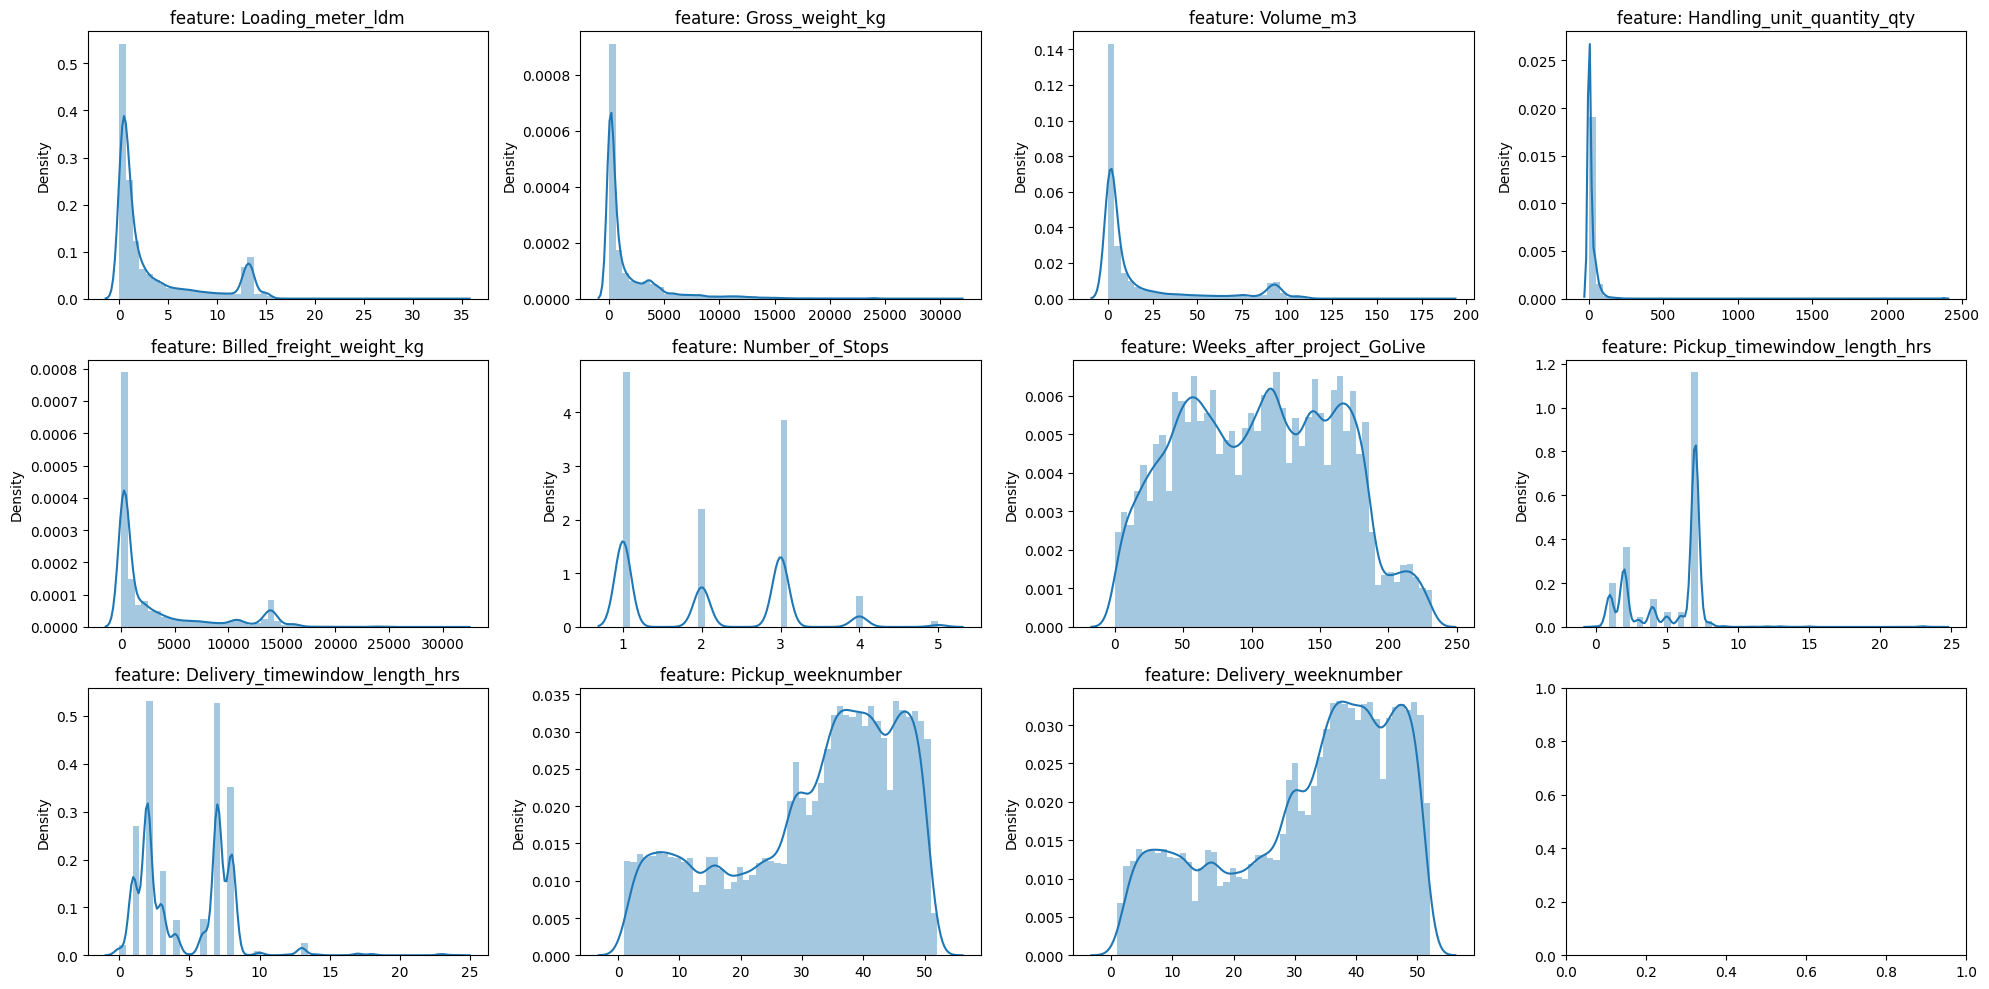

In [27]:
# plot the disrtibution of my numeric features
plt.figure()
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for idx, feat in enumerate(numeric_cols):
    ax = axes[int(idx / 4), idx % 4]
    sns.distplot(data_preproc_conv_no_nans[feat][data_preproc_conv_no_nans[feat]!=-999], ax=ax)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(feat))
fig.tight_layout()
fig.show()

### scaling:

/var/folders/9_/k5r65n5n07s301lfrxbbnf140000gn/T/ipykernel_36430/2170062058.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_numeric_scaled[feat], ax=ax)
/var/folders/9_/k5r65n5n07s301lfrxbbnf140000gn/T/ipykernel_36430/2170062058.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_numeric

<Figure size 640x480 with 0 Axes>

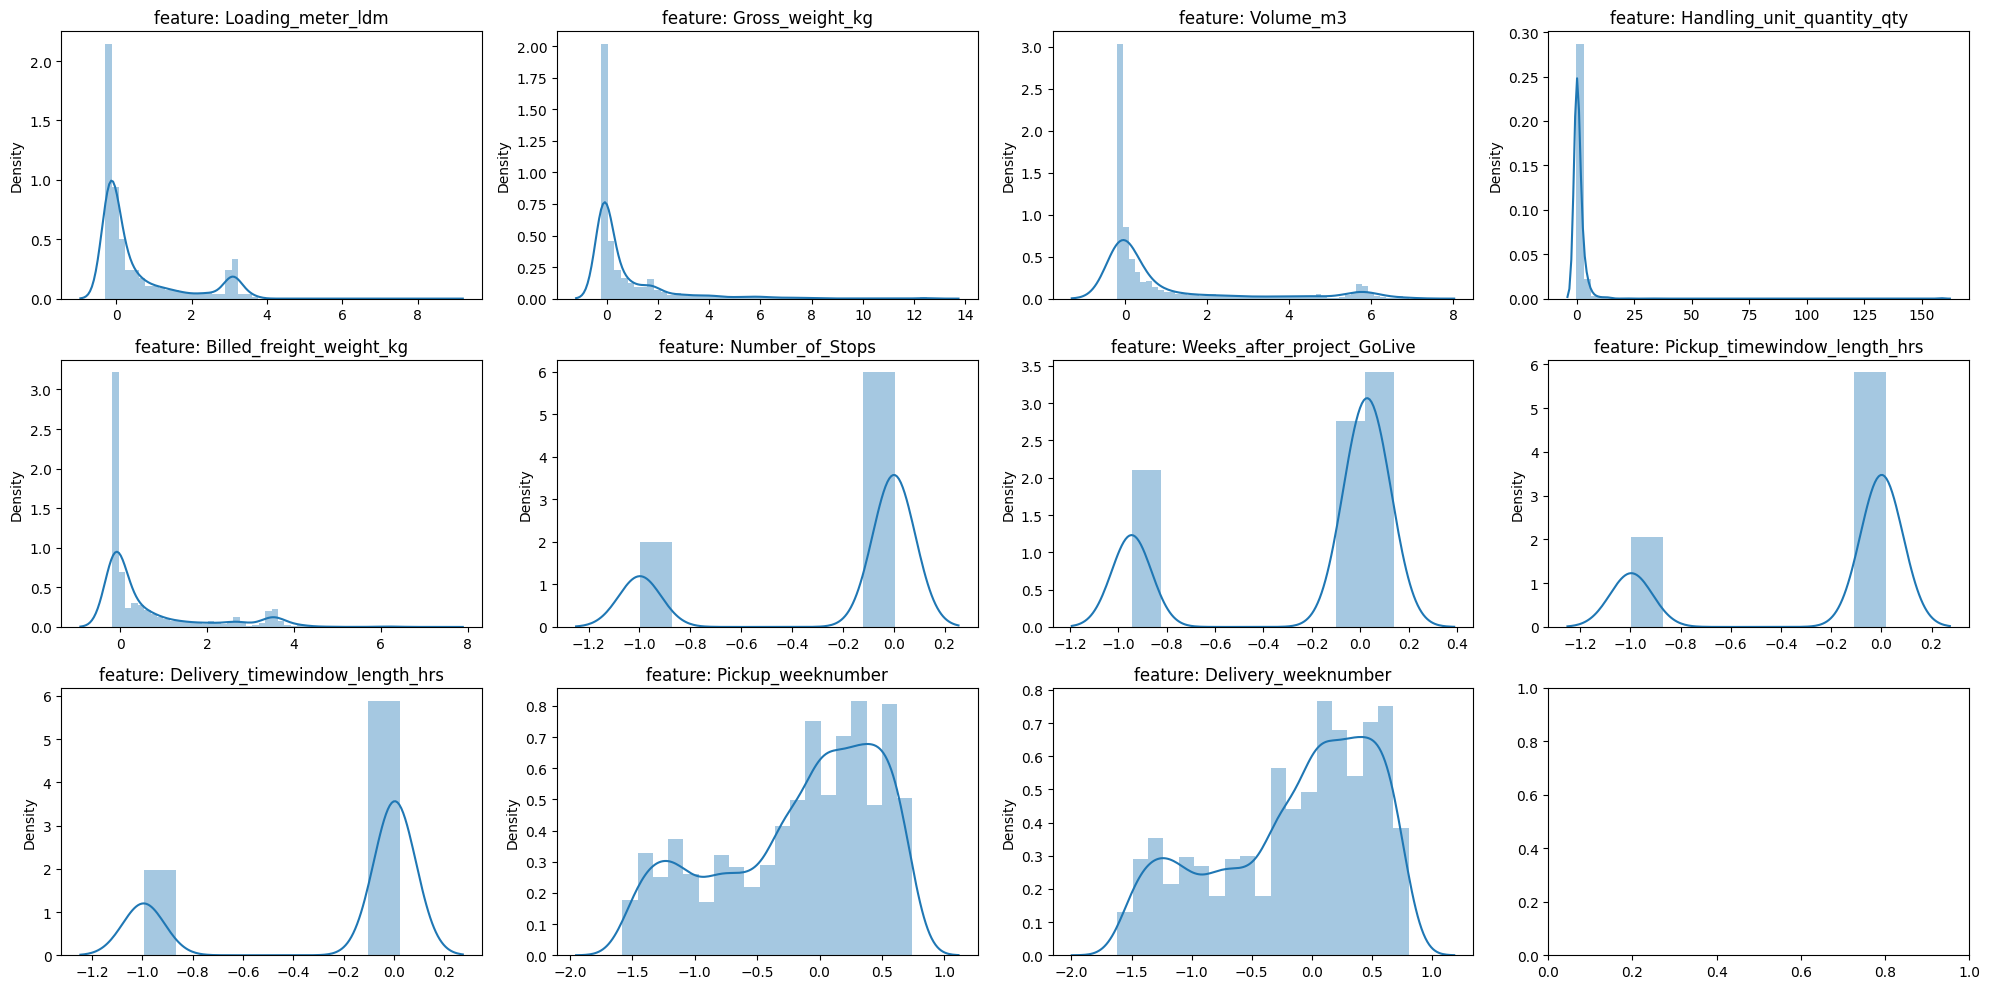

In [28]:
# plot the distribution of the numeric features after standardization
mask_numeric = (X_numeric== -999).any(axis=1)
#X_numeric_scaled = pd.DataFrame(StandardScaler().fit_transform(X_numeric[mask_numeric]), columns=X_numeric.columns)
X_numeric_scaled = pd.DataFrame(RobustScaler().fit_transform(X_numeric[mask_numeric]), columns=X_numeric.columns)
plt.figure()
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
for idx, feat in enumerate(numeric_cols):
    ax = axes[int(idx / 4), idx % 4]
    sns.distplot(X_numeric_scaled[feat], ax=ax)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(feat))
fig.tight_layout()
fig.show()



In [29]:
X_numeric_nomask = X_numeric[~mask_X_numeric]
X_numeric_nomask = X_numeric_nomask.reset_index(drop=True)

In [30]:
X_numeric_nomask[X_numeric_nomask['Handling_unit_quantity_qty']> 2000]

,Loading_meter_ldm,Gross_weight_kg,Volume_m3,Handling_unit_quantity_qty,Billed_freight_weight_kg,Number_of_Stops,Weeks_after_project_GoLive,Pickup_timewindow_length_hrs,Delivery_timewindow_length_hrs,Pickup_weeknumber,Delivery_weeknumber
79638,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79639,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79640,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79641,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79642,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
...,...,...,...,...,...,...,...,...,...,...,...
79775,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79776,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79777,13.6,693.06,24.99,2380,10880.0,3,68,7,6,45,45
79778,13.3,752.55,24.39,2269,10678.08,3,68,7,6,45,45


In [ ]:
# create the box plot for all numeric features
plt.figure(figsize=(20, 10))
fig, axes = plt.subplots(5,5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X_numeric_nomask.columns):
    sns.boxplot(x=y, y=X_numeric_nomask[col], ax=axes[i])
plt.tight_layout()
plt.show()

In [33]:
X_numeric_nomask.shape

(90749, 11)

In [34]:
X_numeric

,Loading_meter_ldm,Gross_weight_kg,Volume_m3,Handling_unit_quantity_qty,Billed_freight_weight_kg,Number_of_Stops,Weeks_after_project_GoLive,Pickup_timewindow_length_hrs,Delivery_timewindow_length_hrs,Pickup_weeknumber,Delivery_weeknumber
Transport Order id,,,,,,,,,,,
VBDK1645,13.0,14136.72,92.66,78,14136.72,1,95,2,2,28,28
VBEF1807,13.0,14136.72,92.66,78,14136.72,1,96,2,2,28,29
VBEMAWJR,13.5,7000.0,97.2,72,14580.0,1,9,2,2,28,28
VBEMAWJT,13.5,7000.0,97.2,72,14580.0,1,9,2,2,28,28
VBEMAWKW,13.0,24000.0,93.6,78,24000.0,1,27,1,1,28,28
...,...,...,...,...,...,...,...,...,...,...,...
VBYR1645,15.0,16119.0,105.3,90,16119.0,1,33,1,1,50,51
VBYR1646,15.0,16076.3,105.3,90,16076.3,1,33,1,1,50,51
VBYR1647,13.8,15299.54,90.77,82,15299.54,1,33,1,1,50,51


<Figure size 2000x1000 with 0 Axes>

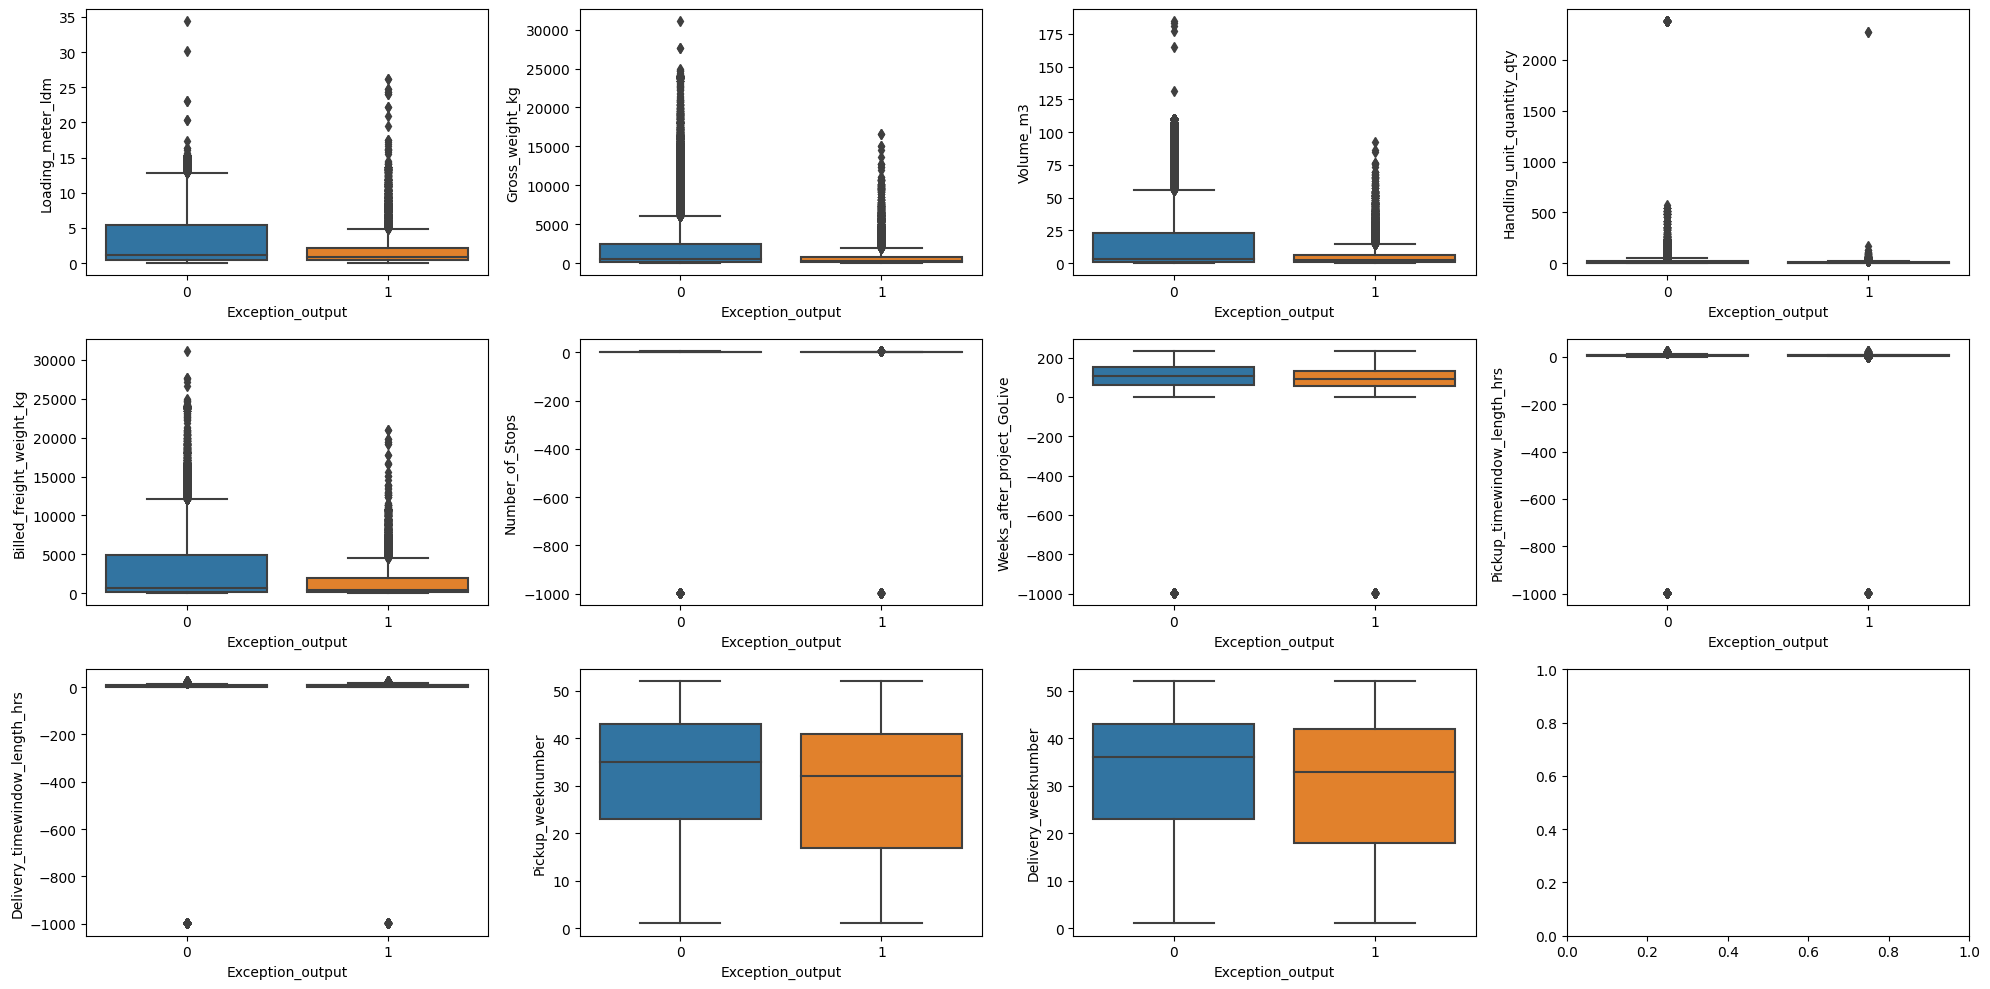

In [35]:
# box plot for all numeric features
plt.figure(figsize=(20, 10))
# create box plots for all numeric features
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X_numeric):
    sns.boxplot(x=y, y=X_numeric[col], ax=axes[i])
plt.tight_layout()
plt.show()

### Feature Selection

a) Information Gain

In [36]:
mutual_info = mutual_info_classif(X_categorical_filtered, y_categorical_filtered.astype('int'))
mutual_info

array([0.00687811, 0.00328402, 0.05222922, 0.00443206, 0.00962706,
       0.00526536, 0.01982718, 0.00760705, 0.01870634, 0.02535321,
       0.00290505, 0.03166701, 0.02862726, 0.        , 0.02374785])

In [37]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_categorical_filtered.columns
mutual_info.sort_values(ascending=False)

Mode_of_Transportation                      0.052229
Exception_happened_1week_ago                0.031667
Exception_happened_2weeks_ago               0.028627
Custom_clearance_needed                     0.025353
distance_cluster                            0.023748
Recipient_country                           0.019827
Pickup_Year                                 0.018706
Delivery_weekday                            0.009627
Pickup_Month                                0.007607
Means_of_transportation                     0.006878
Consignor_country                           0.005265
Pickup_weekday                              0.004432
Carrier_ID                                  0.003284
Plant_Shutdown_on_pickup_or_delivery_day    0.002905
Holiday_during_pickup_or_delivery_day       0.000000
dtype: float64

<Axes: >

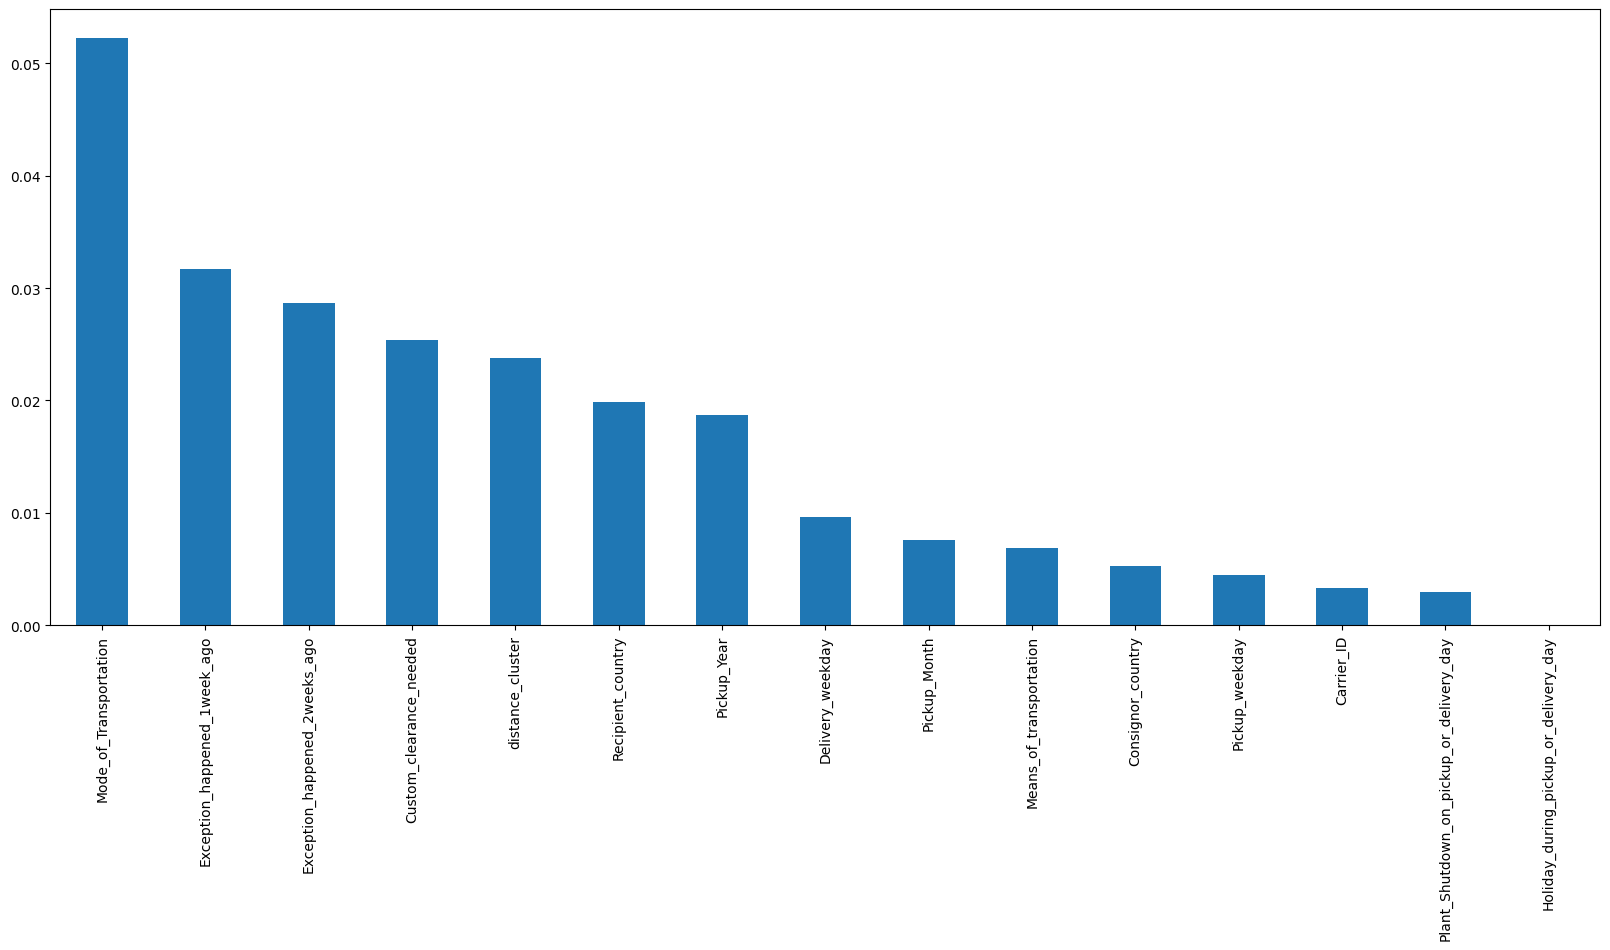

In [38]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [39]:
#Build 3 train data and test datasets
#no MI score curation
#X_train_categorical_fs, X_test_categorical_fs, y_train_categorical_fs, y_test_categorical_fs

#MI scores larger than 0.02
mi_score_selected_index_2 = np.where(mutual_info >0.02)[0]
X_train_categorical_fs_2 = X_train_categorical_fs.iloc[:,mi_score_selected_index_2]
X_test_categorical_fs_2 = X_test_categorical_fs.iloc[:,mi_score_selected_index_2]

#Mi scores less than 0.2
mi_score_selected_index_3 = np.where(mutual_info <= 0.02)[0]
X_train_categorical_fs_3 = X_train_categorical_fs.iloc[:,mi_score_selected_index_3]
X_test_categorical_fs_3 = X_test_categorical_fs.iloc[:,mi_score_selected_index_3]

In [40]:
from sklearn.tree import DecisionTreeClassifier as DTC
model_1 = DTC().fit(X_train_categorical_fs,y_train_categorical_fs.astype(int))
model_2 = DTC().fit(X_train_categorical_fs_2,y_train_categorical_fs.astype(int))
model_3 = DTC().fit(X_train_categorical_fs_3,y_train_categorical_fs.astype(int))
score_1 = model_1.score(X_test_categorical_fs,y_test_categorical_fs.astype(int))
score_2 = model_2.score(X_train_categorical_fs_2,y_train_categorical_fs.astype(int))
score_3 = model_3.score(X_train_categorical_fs_3,y_train_categorical_fs.astype(int))
print(f"score_1:{score_1}\n score_2:{score_2}\n score_3:{score_3}")

score_1:0.8887667619256979
 score_2:0.8750072535252132
 score_3:0.9126211338710614


b) Chi-square Test

In [41]:
from scipy.stats import chi2_contingency
chi2_check = []
for i in X_categorical.columns:
    if chi2_contingency(pd.crosstab(data_preproc_conv_no_nans['Exception_output'], data_preproc_conv_no_nans[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [X_categorical.columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

                                      Column              Hypothesis
0                    Means_of_transportation  Reject Null Hypothesis
1                                 Carrier_ID  Reject Null Hypothesis
2                     Mode_of_Transportation  Reject Null Hypothesis
3                             Pickup_weekday  Reject Null Hypothesis
4                           Delivery_weekday  Reject Null Hypothesis
5                          Consignor_country  Reject Null Hypothesis
6                          Recipient_country  Reject Null Hypothesis
7                               Pickup_Month  Reject Null Hypothesis
8                                Pickup_Year  Reject Null Hypothesis
9                    Custom_clearance_needed  Reject Null Hypothesis
10  Plant_Shutdown_on_pickup_or_delivery_day  Reject Null Hypothesis
11              Exception_happened_1week_ago  Reject Null Hypothesis
12             Exception_happened_2weeks_ago  Reject Null Hypothesis
13     Holiday_during_pickup_or_de

d) correlation coefficient

<Axes: >

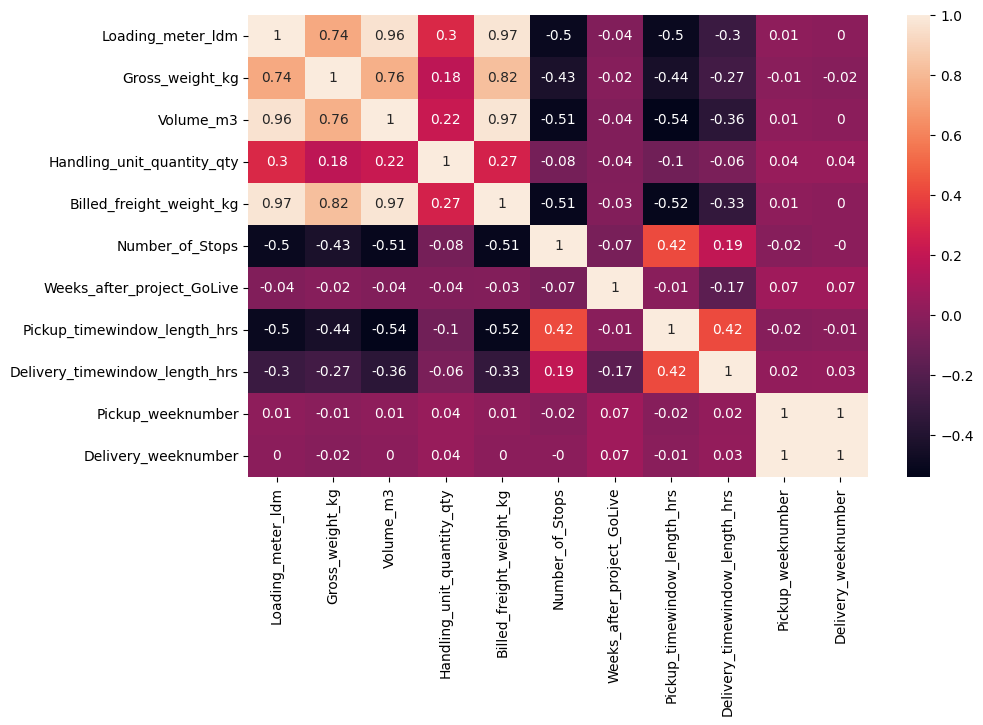

In [42]:
# create boolean mask for rows with -999 value
mask = (X_numeric == -999).any(axis=1)

# filter DataFrame to exclude rows with -999 value
X_numeric_filtered = X_numeric[~mask]

cor = X_numeric_filtered.corr().round(2)
# Plotting Heatmaap showing only lower triangle
plt.figure(figsize = (10,6))
sns.heatmap(cor, annot = True)

Sources:
-   https://www.eurosender.com/blog/en/calculate-ldm-shipping/

remove features that correlate highly with each other: <br>
- Delivery_weeknumber
- Loading_meter_Idm
- Billed_freight_weight_kg

In [65]:
data_preproc_conv_no_nans_trunc = data_preproc_conv_no_nans.drop(["Delivery_weeknumber",'Loading_meter_ldm','Billed_freight_weight_kg'], axis=1)

In [66]:
X = data_preproc_conv_no_nans_trunc.drop('Exception_output', axis=1)
y = data_preproc_conv_no_nans_trunc['Exception_output']
# do not include -999 in the scaling
#mask = (X == -999).any(axis=1)
#X_nomask = X[~mask]
# scale the data
#scaler = RobustScaler()
#X_nomask_scaled = scaler.fit_transform(X_nomask)
#X_mask = X[mask]
#X = np.concatenate((X_nomask_scaled, X_mask), axis=0)
# 5% training, keep ratio between output classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y)


In [148]:
data_raw['Exception_output'].unique()

array(['Good', 'Red'], dtype=object)

In [142]:
len(X),len(X_train),len(X_test),len(y),len(y_train),len(y_test)

(94460, 89737, 4723, 94460, 89737, 4723)

# XGBoost

In [49]:
# sum of negative point/ sum of positive points in the data set
sum(y == 0) / sum(y == 1)

6.819536423841059

In [ ]:
# define xgboost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

# define parameter grid
param_grid = {
    'max_depth': [6, 7, 8, 9, 10],
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.2, 0.3, 0.5, 1],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [0, 0.5, 1],
    'lambda': [0, 0.5, 1, 2, 5],
}

# define scoring metric as precision
scoring = 'f1'

# create grid search instance
grid_search = GridSearchCV(xgb_clf, param_grid, scoring=scoring, cv=10, n_jobs=-1)

# fit grid search on training data
grid_search.fit(X_train, y_train)

# get best score and best parameters
best_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Best score: {best_score}')
print(f'Best parameters: {best_params}')

best_xgb_clf = xgb.XGBClassifier(**best_params,random_state=42, missing=-999, n_jobs=-1)

# Fit the model on the training data
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                    eval_metric='logloss', early_stopping_rounds=10)

In [133]:
# train XGBoost model
best_params = {
    'gamma': 0, 'eta': 0.3, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 400, 
    'lambda': 1, 'scale_pos_weight': 7
    }

best_xgb_clf = xgb.XGBClassifier(**best_params,random_state=42, missing=-999, n_jobs=-1,eval_metric='logloss')

# Fit the model on the training data
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                    early_stopping_rounds=10)


[0]	validation_0-logloss:0.57941	validation_1-logloss:0.58059


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[1]	validation_0-logloss:0.51526	validation_1-logloss:0.51845
[2]	validation_0-logloss:0.47382	validation_1-logloss:0.47783
[3]	validation_0-logloss:0.44350	validation_1-logloss:0.44888
[4]	validation_0-logloss:0.41972	validation_1-logloss:0.42805
[5]	validation_0-logloss:0.40130	validation_1-logloss:0.41139
[6]	validation_0-logloss:0.38478	validation_1-logloss:0.39576
[7]	validation_0-logloss:0.36941	validation_1-logloss:0.38075
[8]	validation_0-logloss:0.35809	validation_1-logloss:0.37148
[9]	validation_0-logloss:0.34759	validation_1-logloss:0.36154
[10]	validation_0-logloss:0.33827	validation_1-logloss:0.35232
[11]	validation_0-logloss:0.33259	validation_1-logloss:0.34724
[12]	validation_0-logloss:0.32177	validation_1-logloss:0.33822
[13]	validation_0-logloss:0.31878	validation_1-logloss:0.33538
[14]	validation_0-logloss:0.31354	validation_1-logloss:0.33167
[15]	validation_0-logloss:0.31205	validation_1-logloss:0.33011
[16]	validation_0-logloss:0.30793	validation_1-logloss:0.32721
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=0, missing=-999,
              monotone_constraints=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, ...)

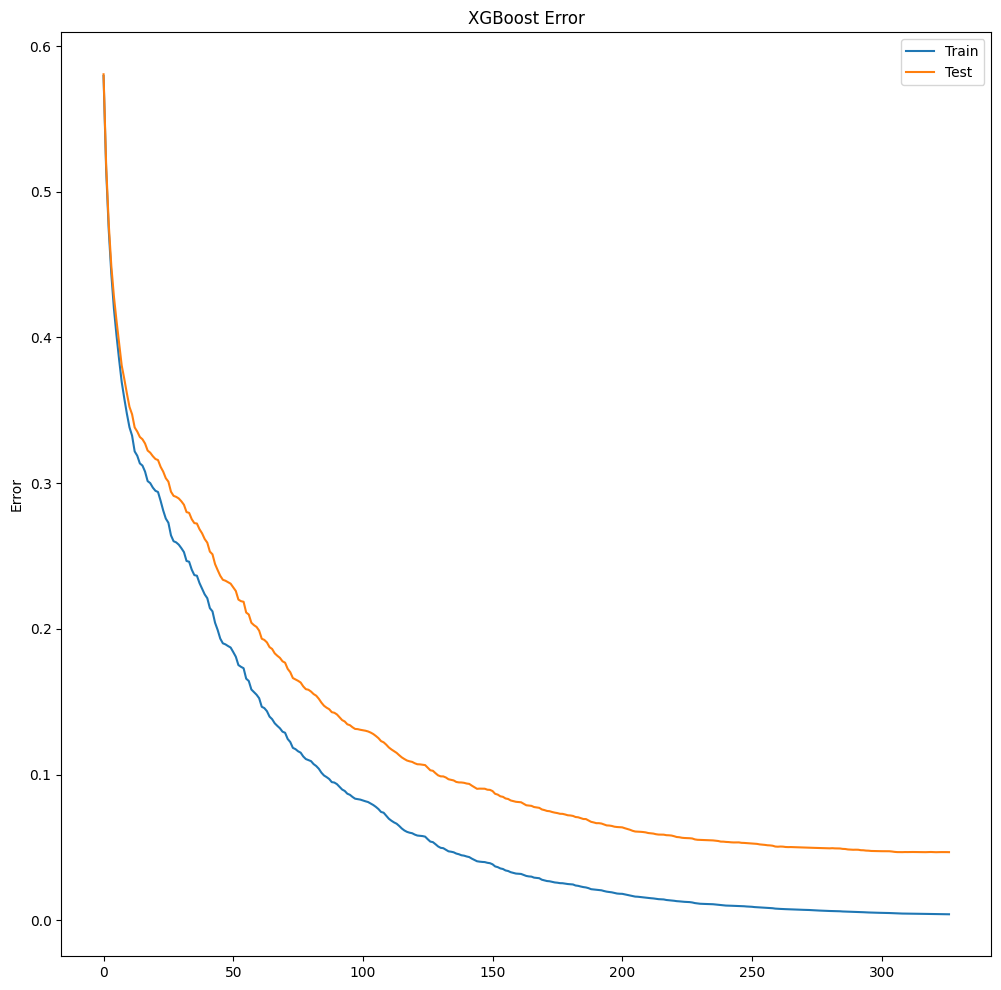

0.04667498343590984
316
Accuracy: 0.9896252381960619
F1-score: 0.95878889823381
ROC AUC: 0.9911237537562161
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4119
         1.0       0.97      0.94      0.96       604

    accuracy                           0.99      4723
   macro avg       0.98      0.97      0.98      4723
weighted avg       0.99      0.99      0.99      4723

Train Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     78261
         1.0       1.00      1.00      1.00     11476

    accuracy                           1.00     89737
   macro avg       1.00      1.00      1.00     89737
weighted avg       1.00      1.00      1.00     89737



In [134]:
# visualize the learning curve
results = best_xgb_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
# Print the best score and iteration
print(best_xgb_clf.best_score)
print(best_xgb_clf.best_iteration)

# evaluate new classifier on test data
y_pred = best_xgb_clf.predict(X_test)
y_pred_train = best_xgb_clf.predict(X_train)
y_prob = best_xgb_clf.predict_proba(X_test)[:, 1]

# print classification metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob)}')
print('Classification Report:\n',classification_report(y_test, y_pred))
print('Train Classification Report:\n',classification_report(y_train, y_pred_train))
#print('Cross Validation Score:\n',cross_val_score(best_xgb_clf, X_train, y_train, cv=5))


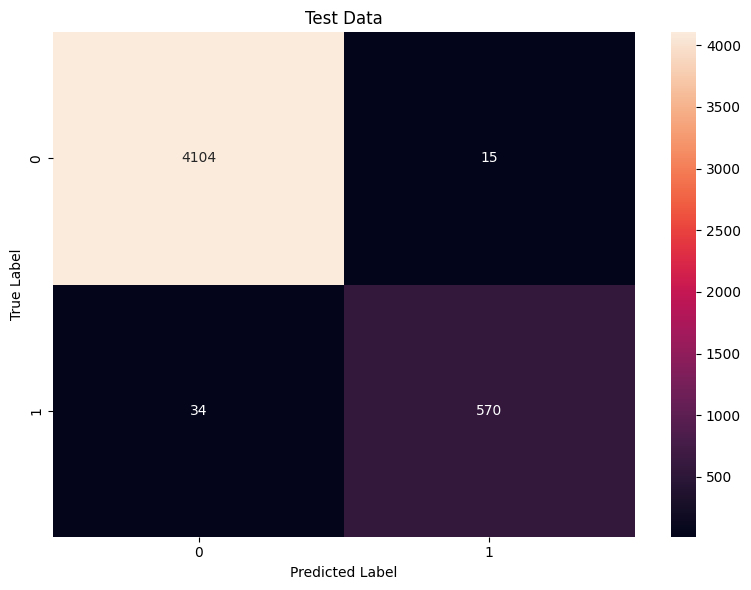

In [135]:
# plot the confusion matrix for both train and test data
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=ax)
ax.set_title('Test Data')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

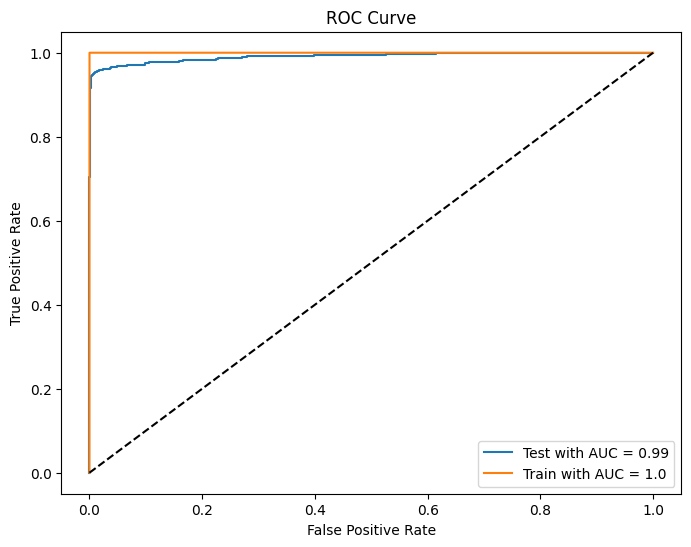

In [136]:
# plot the ROC curve for both train and test data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
train_auc = roc_auc_score(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
#fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
# show only 2 decimals for AUC
auc = np.round(auc, 2)
train_auc = np.round(train_auc, 2)
plt.plot(fpr, tpr, label=f'Test with AUC = {auc}')
plt.plot(fpr_train, tpr_train, label=f'Train with AUC = {train_auc}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best Threshold: 0.263805


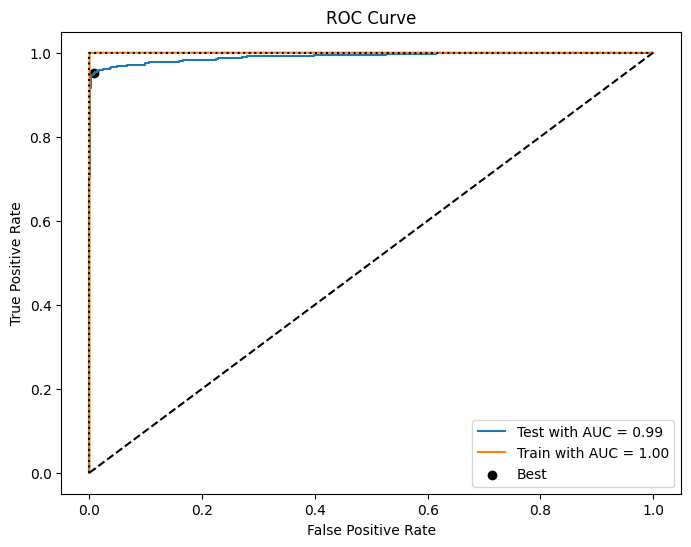

In [137]:
import numpy as np
# plot roc curve given the best threshold using youden's index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Test with AUC = %0.2f' % auc)
plt.plot(fpr_train, tpr_train, label='Train with AUC = %0.2f' % train_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot([0, 0, 1], [0, 1, 1], color='black', linestyle=':')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

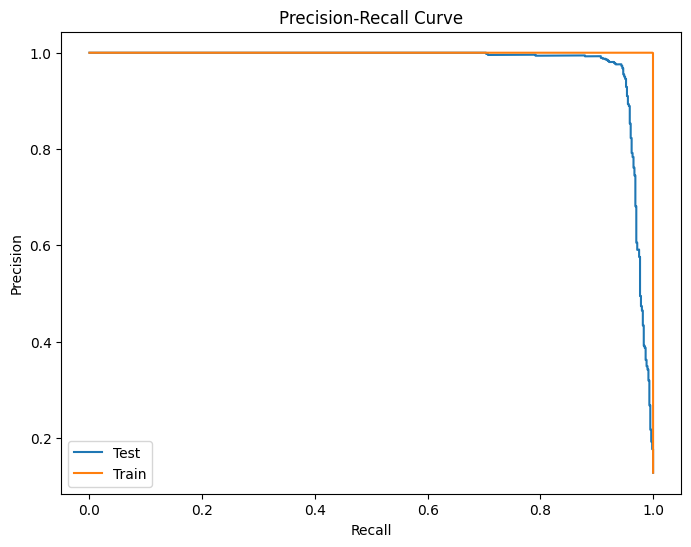

In [138]:
# plot the precision-recall curve for both train and test data
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Test')
plt.plot(recall_train, precision_train, label='Train')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4119
         1.0       0.95      0.95      0.95       604

    accuracy                           0.99      4723
   macro avg       0.97      0.97      0.97      4723
weighted avg       0.99      0.99      0.99      4723



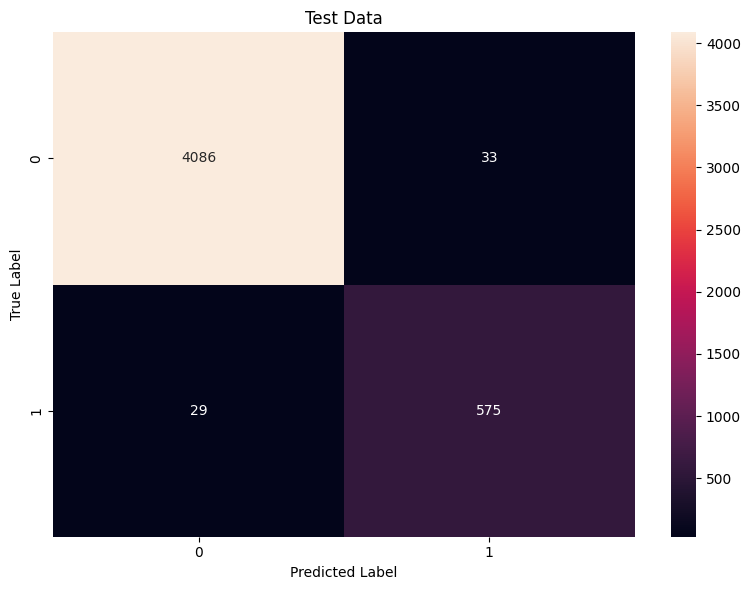

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [139]:
# use the best threshold to predict the labels
y_pred = (y_prob >= best_thresh).astype(int)
y_pred_train = (best_xgb_clf.predict_proba(X_train)[:, 1] >= best_thresh).astype(int)

# print classification metrics
print('Classification Report:\n',classification_report(y_test, y_pred))

# plot the confusion matrix for both train and test data
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=ax)
ax.set_title('Test Data')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

# plot the ROC curve for both train and test data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
train_auc = roc_auc_score(y_train, best_xgb_clf.predict_proba(X_train)[:, 1])
plt.figure(figsize=(8, 6))

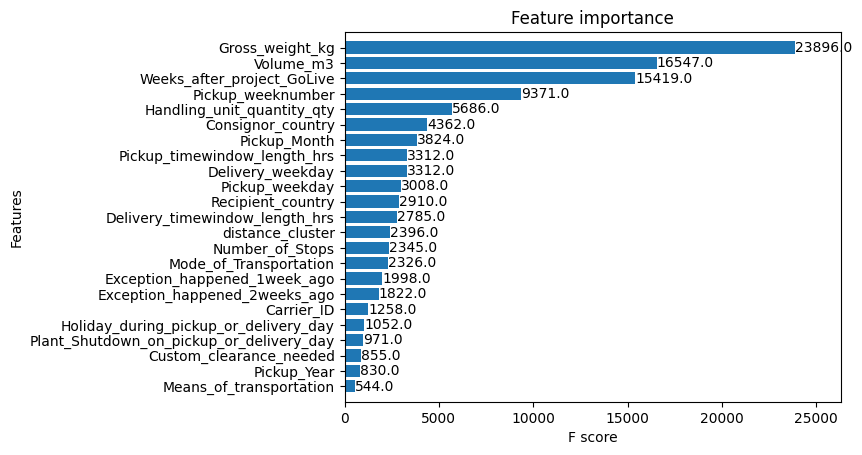

In [140]:
# plot the importance
xgb.plot_importance(best_xgb_clf, height=0.8, grid=False)
plt.show()

# SHAP

In [115]:
import shap
shap.initjs()  # initialize the required JavaScript libraries

#compute the shap values for all features in the test set
explainer = shap.TreeExplainer(best_xgb_clf)
shap_values = explainer.shap_values(X_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [116]:
# add an indexer to the test set that starts from 0
X_test_indexed = X_test.copy()
X_test_indexed['index'] = range(0, len(X_test_indexed))

In [117]:
# visualize the first prediction's explanation with white background
shipment_code = 'VBMV1080'
point_of_interest = X_test_indexed[X_test_indexed.index == shipment_code]['index']
shap.force_plot(explainer.expected_value, shap_values[point_of_interest,:], X_test.iloc[point_of_interest,:])

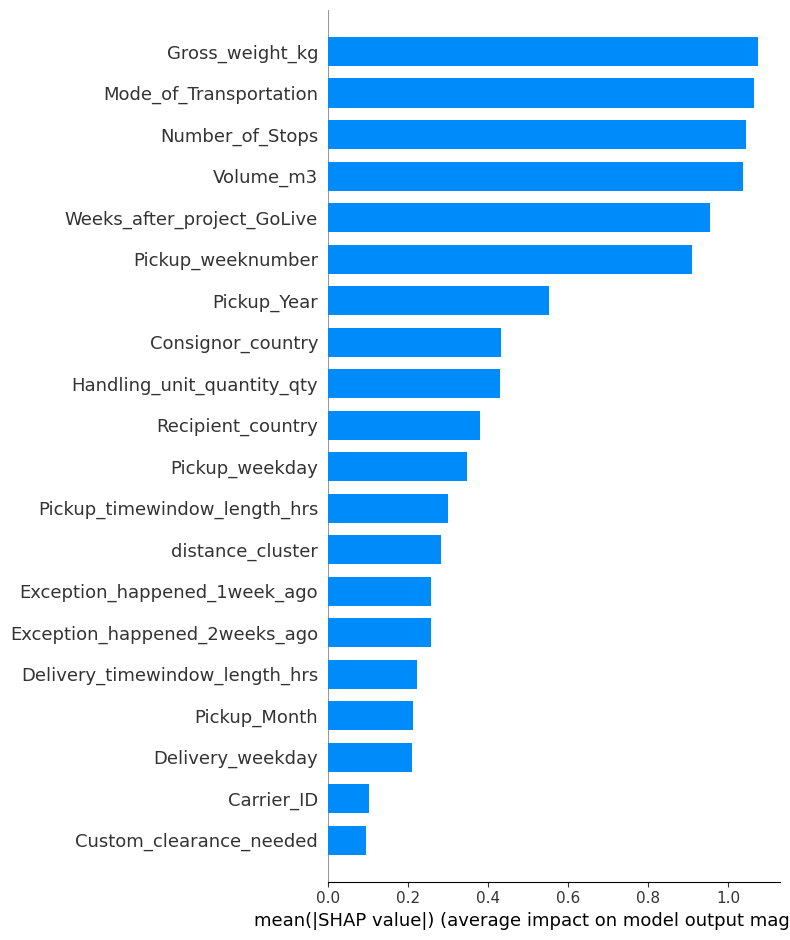

In [118]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


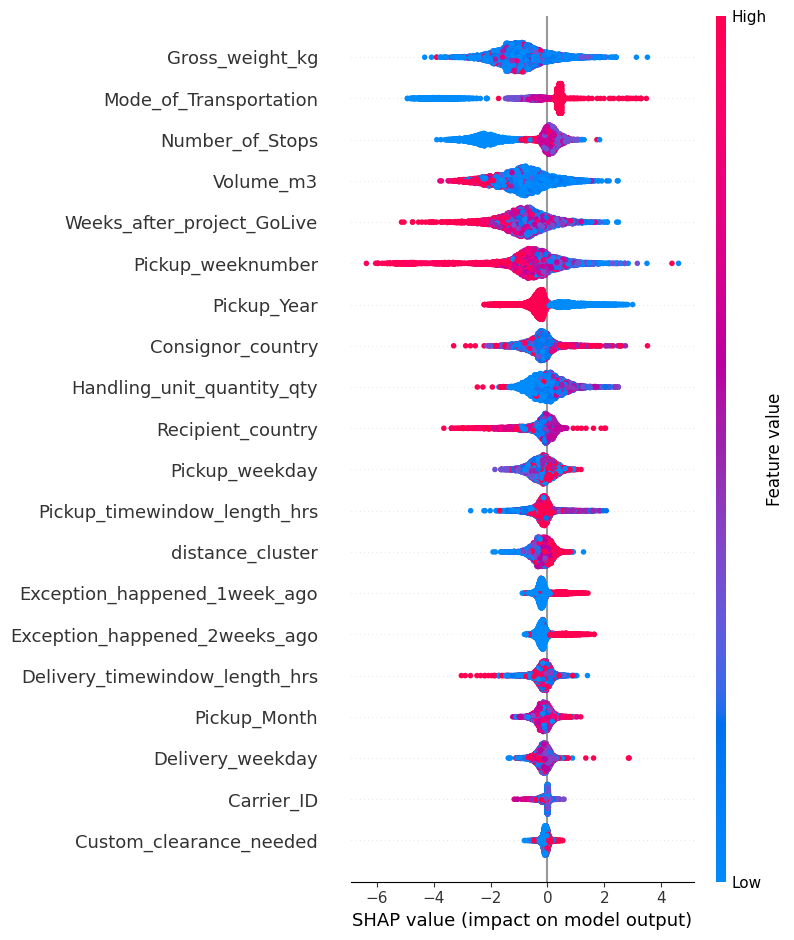

In [119]:
shap.summary_plot(shap_values, X_test)

In [120]:
prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
prediction_df.index = X_test.index
# add X_test to the prediction_df
#prediction_df = pd.concat([X_test, prediction_df], axis=1)

In [121]:
# prediction_df where the model predicted the wrong label when actual label is 1
prediction_df[(prediction_df['Actual'] == 1) & (prediction_df['Actual'] != prediction_df['Predicted'])]

,Actual,Predicted
Transport Order id,,
VBIG0196,1,0
VBJB1540,1,0
VBOZ1706,1,0
VBJB0548,1,0
VBTA0273,1,0
VBMV1080,1,0
VBYK0655,1,0
VBGQ0171,1,0
VBJB0548,1,0


In [122]:
prediction_df.head(5)

,Actual,Predicted
Transport Order id,,
VBYK0666,0,0
VBVE1008,0,0
VBHS0219,0,0
VBJP0658,0,0
VBUC1013,0,0


In [123]:
X_test[X_test.index == 'VBRY0307'].T

Transport Order id
Gross_weight_kg
Volume_m3
Handling_unit_quantity_qty
Means_of_transportation
Carrier_ID
Mode_of_Transportation
Pickup_weekday
Delivery_weekday
Consignor_country
Recipient_country


# Logistic Regression

Accuracy: 0.8738090196908744
F1-score: 0.07453416149068325
ROC AUC: 0.809700724634186
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      4119
         1.0       0.60      0.04      0.07       604

    accuracy                           0.87      4723
   macro avg       0.74      0.52      0.50      4723
weighted avg       0.84      0.87      0.82      4723



<Figure size 640x480 with 0 Axes>

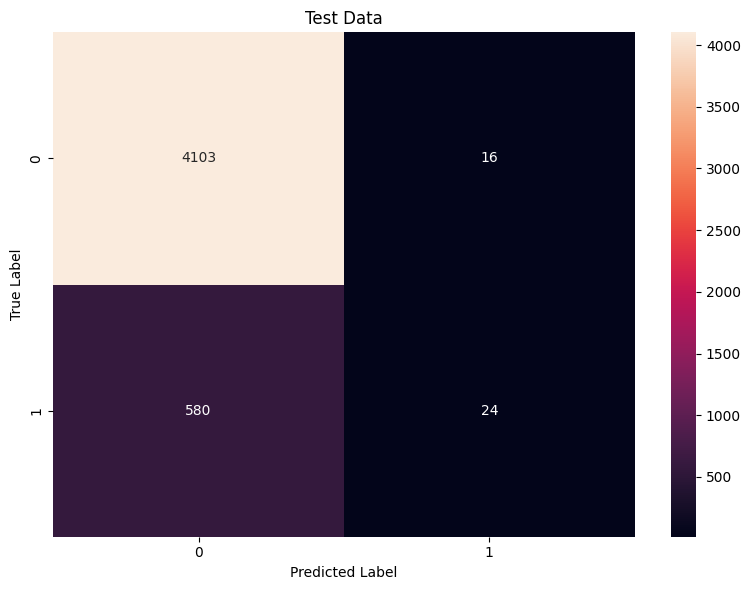

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [132]:
# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the model with regularization
log_reg = LogisticRegression(C=1, penalty='l2', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# predict the labels
y_pred = log_reg.predict(X_test_scaled)
y_pred_train = log_reg.predict(X_train_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# print classification metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prob)}')
print('Classification Report:\n',classification_report(y_test, y_pred))

# plot the confusion matrix for both train and test data
plt.figure()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=ax)
ax.set_title('Test Data')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

# plot the ROC curve for both train and test data
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
train_auc = roc_auc_score(y_train, y_pred_train)

